In [1]:
# source projvenv/bin/activate
# python3 -m pip install spellwise cProfile

In [2]:
from classes.Utils import *
from classes.CRV import *
from classes.Corpus import *
from classes.Vectorizer import *

In [3]:
import tensorflow as tf
from itertools import *
from glob import glob
import numpy as np
import random
import os

from tensorflow import keras

print(f'Tensorflow Version : {tf.__version__}')
print(f'Keras Version : {keras.__version__}')
print(' ')
print(f'Devices available: {[device.name for device in tf.config.list_physical_devices()]}')
print(' ')
print(f'Num GPUs available: {len(tf.config.list_physical_devices('GPU'))}')
#print(f'Memory info : {tf.config.experimental.get_memory_info('GPU:0')}')
print(' ')

Tensorflow Version : 2.20.0
Keras Version : 3.10.0
 
Devices available: ['/physical_device:CPU:0']
 
Num GPUs available: 0
 


In [4]:

@tf.keras.utils.register_keras_serializable(name = 'RICNFormer')
class RICNFormer(keras.layers.Layer):
    def __init__(self, num_ideas = 64, position_size = 33, **kwargs):
        super().__init__(**kwargs)

        self.num_ideas = num_ideas
        self.position_size = position_size


    def build(self, input_shape):
        self.vector_size = input_shape[-1]

        self.match_ideas    = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                              initializer = "glorot_uniform", name="match_ideas") # main
        self.search_ideas   = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                              initializer = "glorot_uniform", name="search_ideas")# context
        self.position_ideas = self.add_weight(shape = (self.position_size, self.num_ideas), 
                                              initializer = "glorot_uniform", name="position_ideas")
        self.thoughts       = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                              initializer = "zeros", name="thoughts")


    def call(self, inputs):
        return tf.map_fn(self.transform, inputs, fn_output_signature = tf.RaggedTensorSpec(shape=(None,self.vector_size), ragged_rank = 0, dtype = tf.float32))
    

    def transform(self, sequence):
        match_activations  = keras.ops.einsum('wv,vi->wi', sequence, self.match_ideas)  # main word, ideas
        search_activations = keras.ops.einsum('wv,vi->wi', sequence, self.search_ideas) # context word, ideas

        match_activations  = keras.ops.expand_dims(match_activations, axis = 1)  # main word, 0 ideas
        search_activations = keras.ops.expand_dims(search_activations, axis = 0) # 0, context word, ideas


        x_indices, y_indices = tf.meshgrid(tf.range(tf.shape(sequence)[0]), tf.range(tf.shape(sequence)[0]))
        positional_encoding = (x_indices - y_indices) + (self.position_size // 2)
        positional_encoding = tf.one_hot(positional_encoding, self.position_size)

        position_activations = keras.ops.einsum('mcp,pi->mci', positional_encoding, self.position_ideas)

        idea_activations = match_activations + search_activations + position_activations # main word, context word, ideas
        idea_activations = keras.ops.einsum('mci,mc->mci', idea_activations, 1 - keras.ops.eye(tf.shape(sequence)[0]))

        per_word_activations = keras.ops.sum(idea_activations, axis = 1) # sum context_word, so main_word, idea's activation

        # IF ADDING
        transformation = keras.ops.einsum('wi,vi->wv', per_word_activations, self.thoughts)

        new_sequence = sequence + transformation

        # normalize
        new_sequence = keras.ops.normalize(
            new_sequence - keras.ops.min(new_sequence, axis = -1, keepdims=True), order = 2)
        # The view is transposed, so it is really row, column.
        return new_sequence


@tf.keras.utils.register_keras_serializable(name = 'SqrtFormer')
class SqrtFormer(keras.layers.Layer):
    def __init__(self, num_ideas = 64, position_size = 33, **kwargs):
        super().__init__(**kwargs)

        self.num_ideas = num_ideas
        self.position_size = position_size


    def build(self, input_shape):
        self.vector_size = input_shape[-1]

        self.match_ideas    = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                              initializer = keras.initializers.RandomUniform(minval = .001, maxval = 1),
                                              constraint = keras.constraints.NonNeg(), name="match_ideas") # main
        self.search_ideas   = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                              initializer = keras.initializers.RandomUniform(minval = .001, maxval = 1),
                                              constraint = keras.constraints.NonNeg(), name="search_ideas")# context
        self.position_ideas = self.add_weight(shape = (self.position_size, self.num_ideas), 
                                              initializer = "glorot_uniform", name="position_ideas")
        self.thoughts       = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                              initializer = "zeros", name="thoughts")


    def call(self, inputs):
        return tf.map_fn(self.transform, inputs, fn_output_signature = tf.RaggedTensorSpec(shape=(None,self.vector_size), ragged_rank = 0, dtype = tf.float32))
    
    def get_match_activations(self, inputs):
        activations = keras.ops.expand_dims(inputs, axis = -1)# wv0
        activations *= self.match_ideas# wvi
        activations = keras.ops.sqrt(keras.ops.maximum(activations, 0.00000001))
        activations = keras.ops.sum(activations, axis = 1)# wi
        activations *= activations
        return activations
    
    def get_search_activations(self, inputs):
        activations = keras.ops.expand_dims(inputs, axis = -1)# wv0
        activations *= self.search_ideas# wvi
        activations = keras.ops.sqrt(keras.ops.maximum(activations, 0.00000001))
        activations = keras.ops.sum(activations, axis = 1)# wi
        activations *= activations
        return activations

    def transform(self, sequence):
        match_activations  = self.get_match_activations(sequence)
        search_activations = self.get_search_activations(sequence) # context word, ideas

        match_activations  = keras.ops.expand_dims(match_activations, axis = 1)  # main word, 0 ideas
        search_activations = keras.ops.expand_dims(search_activations, axis = 0) # 0, context word, ideas


        x_indices, y_indices = tf.meshgrid(tf.range(tf.shape(sequence)[0]), tf.range(tf.shape(sequence)[0]))
        positional_encoding = (x_indices - y_indices) + (self.position_size // 2)
        positional_encoding = tf.one_hot(positional_encoding, self.position_size)

        position_activations = keras.ops.einsum('mcp,pi->mci', positional_encoding, self.position_ideas)

        idea_activations = match_activations + search_activations + position_activations # main word, context word, ideas
        idea_activations = keras.ops.einsum('mci,mc->mci', idea_activations, 1 - keras.ops.eye(tf.shape(sequence)[0]))

        per_word_activations = keras.ops.sum(idea_activations, axis = 1) # sum context_word, so main_word, idea's activation

        # IF ADDING
        transformation = keras.ops.einsum('wi,vi->wv', per_word_activations, self.thoughts)

        new_sequence = sequence + transformation

        # normalize
        new_sequence = keras.ops.normalize(
            new_sequence - keras.ops.min(new_sequence, axis = -1, keepdims=True), order = 1)
        # The view is transposed, so it is really row, column.
        return new_sequence



@tf.keras.utils.register_keras_serializable(name = 'TailSlicer')
class TailSlicer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.vector_size = input_shape[-1]

    def call(self, inputs):
        result = tf.map_fn(self.clip, inputs, fn_output_signature=tf.TensorSpec(shape = (self.vector_size)))
        return tf.ensure_shape(result, (None, self.vector_size))
    
    def clip(self, inputs):
        return inputs[-1]
    


@tf.keras.utils.register_keras_serializable(name = 'ProbPredicter')
class ProbPredicter(keras.layers.Layer):
    def __init__(self, out_size, num_ideas = 64, **kwargs):
        super().__init__(**kwargs)

        self.out_size = out_size
        self.num_ideas = num_ideas


    def build(self, input_shape):
        self.vector_size = input_shape[-1]

        self.ideas         = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                             initializer = "glorot_uniform", name="ideas")
        self.distributions = self.add_weight(shape = (self.out_size, self.num_ideas), 
                                             initializer = "glorot_uniform", name="distributions")


    def call(self, inputs):
        activations = keras.ops.einsum('bv,vi->bi', inputs, self.ideas)# can normalize
        activations = keras.ops.einsum('bi,oi->bo', activations, self.distributions)
        return keras.ops.softmax(activations)#bias?


@tf.keras.utils.register_keras_serializable(name = 'MinPredicter')
class MinPredicter(keras.layers.Layer):
    def __init__(self, out_size, num_ideas = 64, **kwargs):
        super().__init__(**kwargs)

        self.out_size = out_size
        self.num_ideas = num_ideas


    def build(self, input_shape):
        self.vector_size = input_shape[-1]

        self.ideas         = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                             initializer = "zeros", name="ideas",
                                             constraint = keras.constraints.NonNeg())
        self.distributions = self.add_weight(shape = (self.out_size, self.num_ideas), 
                                             initializer = "glorot_uniform", name="distributions")


    def call(self, inputs):
        activations = keras.ops.expand_dims(inputs, axis = -1)# bv0
        activations = keras.ops.minimum(activations, keras.ops.normalize(self.ideas, axis = 0, order = 1))# vi
        activations = keras.ops.sum(activations, axis = -2)# bi
        activations = keras.ops.einsum('bi,oi->bo', activations, self.distributions)
        return keras.ops.softmax(activations)#bias?
    

@tf.keras.utils.register_keras_serializable(name = 'SqrtPredicter')
class SqrtPredicter(keras.layers.Layer):
    def __init__(self, out_size, num_ideas = 64, **kwargs):
        super().__init__(**kwargs)

        self.out_size = out_size
        self.num_ideas = num_ideas


    def build(self, input_shape):
        self.vector_size = input_shape[-1]

        self.ideas         = self.add_weight(shape = (self.vector_size, self.num_ideas), 
                                             initializer = keras.initializers.RandomUniform(minval = .001, maxval = 1),
                                             name="ideas",
                                             constraint = keras.constraints.NonNeg())
        self.distributions = self.add_weight(shape = (self.out_size, self.num_ideas), 
                                             initializer = "glorot_uniform", name="distributions")


    def call(self, inputs):
        activations = keras.ops.expand_dims(inputs, axis = -1)# bv0
        activations *= self.ideas# vi
        activations = keras.ops.sqrt(keras.ops.maximum(activations, 0.00000001))
        activations = keras.ops.sum(activations, axis = -2)# bi
        activations *= activations
        activations = keras.ops.einsum('bi,oi->bo', activations, self.distributions)
        return keras.ops.softmax(activations)#bias?

In [5]:


class DataGenerator:
    def __init__(self,
                 corpus,
                 vectorizer,
                 max_length = 16):
        # generation system
        self.corpus = corpus
        self.embedding_matrix = tf.constant(vectorizer.matrix)
        # output shape
        self.max_length = max_length
        # output format
        self.depth = len(self.corpus.vocab)
        
    @tf.function()
    def __call__(self, sentence):
        index = self.get_index(sentence)

        clip = self.get_clip(sentence, index)
        ans = tf.cast(sentence[index], tf.int32)

        clip = tf.nn.embedding_lookup(self.embedding_matrix, clip)
        ans = tf.one_hot(ans, self.depth)

        return clip, ans

    def get_clip(self, sentence, index):
        start_idx = tf.maximum(
            tf.constant(0, dtype = tf.int64),
            index - tf.cast(tf.random.uniform([], maxval = self.max_length) + 1, tf.int64))
        clip = sentence[start_idx:index]
        return clip
    
    @tf.function()
    def get_index(self, sentence):
        word = tf.random.shuffle(tf.unique(sentence[1:])[0])[0] # min length

        indices = tf.where(sentence[1:] == word) + 1
        index = tf.squeeze(tf.random.shuffle(indices)[0])

        return index


In [6]:

class DenseDataGenerator(DataGenerator):
    def __call__(self, sentence):
        clip, ans = super().__call__(sentence)
        return tf.squeeze(clip), ans
    
    def get_clip(self, sentence, index):
        return sentence[index - 1]
    

class EncoderDataGenerator(DenseDataGenerator):
    def get_clip(self, sentence, index):
        return sentence[index]


class HalvesDataGenerator(DataGenerator):
    def __init__(self, corpus, vectorizer, max_length = 16, weight = 1):
        super().__init__(corpus, vectorizer, max_length = max_length)

        self.length_weights = tf.constant([[self.max_length / 2**(x*weight) for x in range(self.max_length - 1)]])
        self.length_weights = tf.math.log(self.length_weights)
    
    def get_clip(self, sentence, index):
        start_idx = tf.maximum(tf.constant(0, dtype = tf.int64), index - tf.cast(tf.random.categorical(self.length_weights, 1)[0][0] + 1, tf.int64))
        clip = sentence[start_idx : index]
        return clip



In [7]:
corpus = Corpus(
    filepath = 'corpora/recipes',
    spell_correct = 'corpora/spelling_dictionary',
    lemmatize = False,
    removal_threshold = 1)

vectorizer = corpus.create_vectorizer(removal_threshold = 2)
# vectorizer.normalize()

Data collected:
    - 4107 unique words found.
    - most common words: ['\n', '-', '.', '1', ',']
    - least common words: ['www', 'yet', 'zinfandel', 'zip', 'zipper']


Corpus loaded:
    - 5000 sentences.
    - longest sentence: 

<START> whole wheat yeast bread 
 
 ingredients : 
 - 1 cup ( 2 2 5 ml ) scalded milk 
 - 1 / 4 cup ( 6 0 ml ) lard 
 - 4 tsp ( 2 0 ml ) . salt 
 - 1 / 4 cup ( 6 0 ml ) honey 
 - 1 cup ( 2 2 5 ml ) water , 1 1 0 - 1 1 5 degrees 
 - 2 pkg . dry yeast 
 - 2 tbsp ( 3 0 ml ) . brown sugar 
 - 2 cups ( 4 7 5 ml ) whole wheat flour 
 - 3 cups ( 7 0 0 ml ) or more white flour 
 
 directions : 
 - mix scalded milk , lard , salt & honey and let cool to lukewarm - about 8 5 degrees ( 3 0 c . ) . 
 - mix water , yeast & brown sugar and let stand to dissolve for 2 - 3 minutes . 
 - add yeast mixture to milk mixture . 
 - add whole wheat flour and enough white flour to make dough . 
 - mix well . 
 - knead 5 - 1 0 minutes . 
 - put in bowl to rise until double in size

In [8]:
batch_size = 64
repeats = 5

dataset = tf.data.Dataset.from_tensor_slices(corpus.get_ragged_int_tensor())
dataset = dataset.repeat(repeats)
dataset = dataset.shuffle(dataset.cardinality(), reshuffle_each_iteration=True)

# data_generator = DataGenerator(corpus, vectorizer, max_length = 48)#, weight = 2/3)
# dataset = dataset.map(data_generator)
# dataset = dataset.ragged_batch(batch_size)
# # dataset = dataset.padded_batch(batch_size)

data_generator = EncoderDataGenerator(corpus, vectorizer)
dataset = dataset.map(data_generator)
dataset = dataset.batch(batch_size)

In [9]:
# inp = keras.layers.Input(shape = [None, vectorizer.csize], ragged = True)
# x = SqrtFormer(num_ideas = 48, position_size = 128)(inp)
# x = TailSlicer()(x)
# out = keras.models.load_model(os.getcwd() + '/RICNlog/SqrtTest.keras').get_layer('sqrt_predicter')(x)
# out.trainable = False

# model = keras.Model(inputs = inp, outputs = out, name = "SqrtRICNFormer")
# optimizer = keras.optimizers.Adam(learning_rate = .005)
# model.compile(optimizer = optimizer, loss = "categorical_crossentropy")

# # model.summary()

In [10]:
inp = keras.layers.Input(shape = [vectorizer.csize])
out = SqrtPredicter(len(corpus.vocab), 32)(inp)

model = keras.Model(inputs = inp, outputs = out, name = "SqrtEncoder")
optimizer = keras.optimizers.Adam(learning_rate = .005)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy")

model.summary()

Model: "SqrtEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3369)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sqrt_predicter (SqrtPredicter)  │ (None, 4107)           │       239,232 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,232 (934.50 KB)

 Trainable params: 239,232 (934.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Load Tensorboard with
#   python3.12 -m tensorboard.main --logdir=~/Desktop/RICN/RICNlog

tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir = os.getcwd() + "/log",
        update_freq = 32
    )

checkpoint_callback = keras.callbacks.ModelCheckpoint(
        os.getcwd() + '/checkpoints/SqrtEncoder.keras',
        'loss', 1, True,
        save_freq = 64
    )

model.fit(dataset, epochs = 512, callbacks = [checkpoint_callback, tensorboard_callback])

Epoch 1/512
 62/391 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 54.4707
Epoch 1: loss improved from inf to 44.90859, saving model to /Users/josh/Documents/GitHub/CRV-Playground/checkpoints/SqrtEncoder.keras
127/391 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 44.8792
Epoch 1: loss improved from 44.90859 to 28.50813, saving model to /Users/josh/Documents/GitHub/CRV-Playground/checkpoints/SqrtEncoder.keras
190/391 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 38.2022
Epoch 1: loss improved from 28.50813 to 21.52738, saving model to /Users/josh/Documents/GitHub/CRV-Playground/checkpoints/SqrtEncoder.keras
253/391 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 33.5517
Epoch 1: loss improved from 21.52738 to 17.59636, saving model to /Users/josh/Documents/GitHub/CRV-Playground/checkpoints/SqrtEncoder.keras
318/391 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 30.0345
Epoch 1: loss improved from 17.59636 to 15.10037, saving model to /Users/josh/Documents/GitHub/CRV-Playground/checkpoints/SqrtEncoder.keras
383

KeyboardInterrupt: 

{ + 8.399999618530273⋅bed + 8.220000267028809⋅tetrazzini + 7.5⋅camembert + 7.429999828338623⋅leg + 7.360000133514404⋅fiesta + 7.309999942779541⋅loose + 7.170000076293945⋅thanksgiving + 7.150000095367432⋅juiced + 6.860000133514404⋅picked + 6.769999980926514⋅dreams + 6.769999980926514⋅juices + 6.75⋅trove + 6.539999961853027⋅discarding + 6.480000019073486⋅intervals + 6.409999847412109⋅crusted + 6.28000020980835⋅damiana + 6.239999771118164⋅envelopes + 6.210000038146973⋅preheat + 6.199999809265137⋅company + 6.159999847412109⋅comte + 813 others}


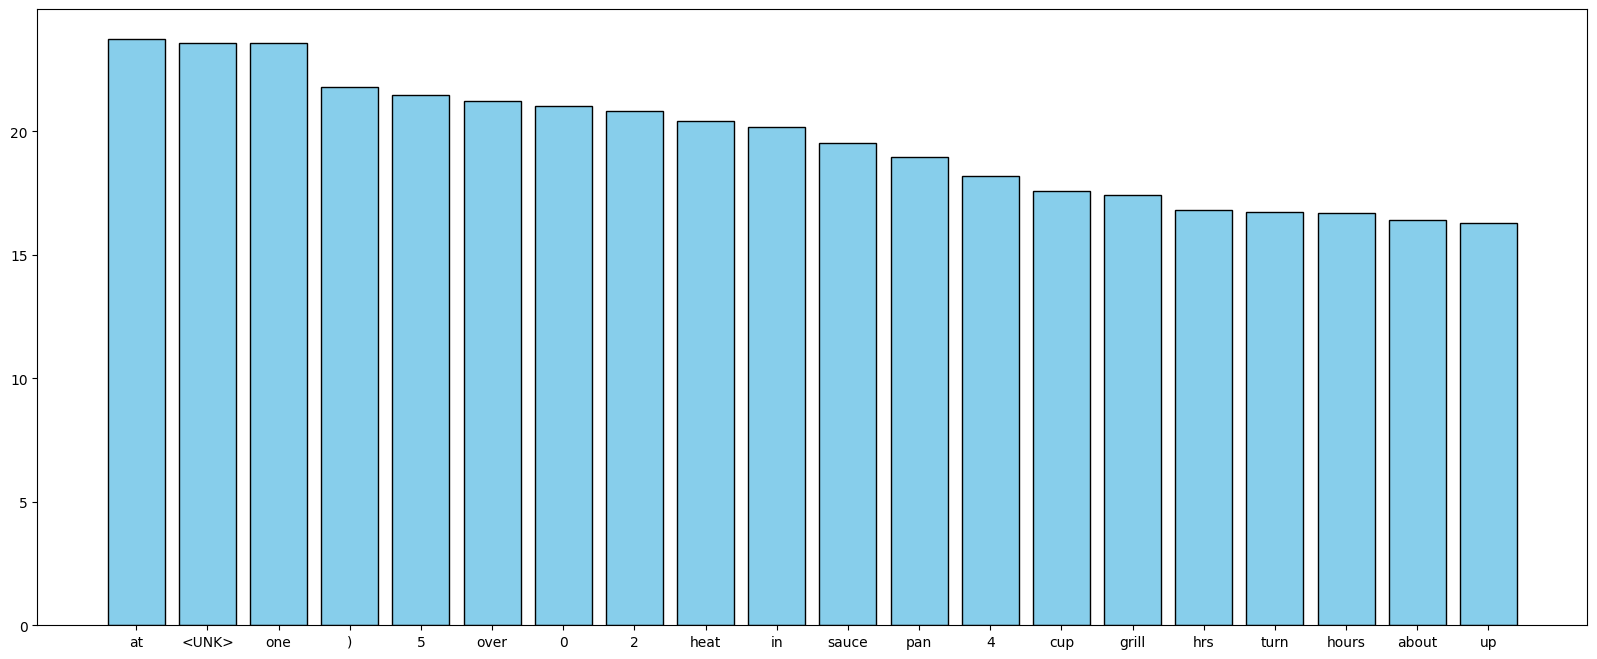

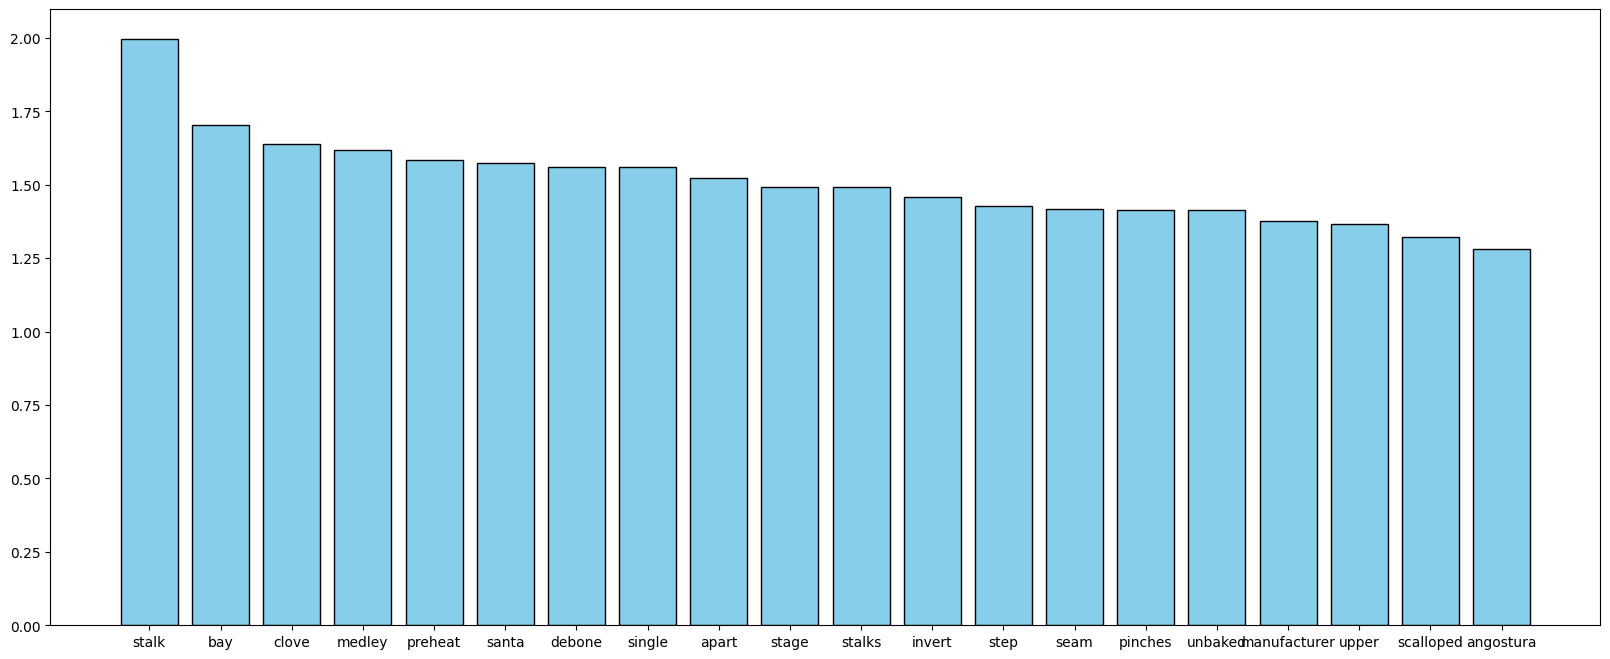

In [20]:
idx = -1
prob_layer = model.get_layer('sqrt_predicter')

ideas = prob_layer.ideas

# print(prob_layer.idea_weights)

plot_dict(vectorizer.rate_words(ideas[:, idx].numpy(), mode = 'sqrt'), start = 20)
print(vectorizer.to_CRV(ideas[:, idx].numpy()))# most is removal tags
plot_dict(sort_hl({word: val for word, val in zip(corpus.vocab, prob_layer.distributions[:, idx].numpy())}))

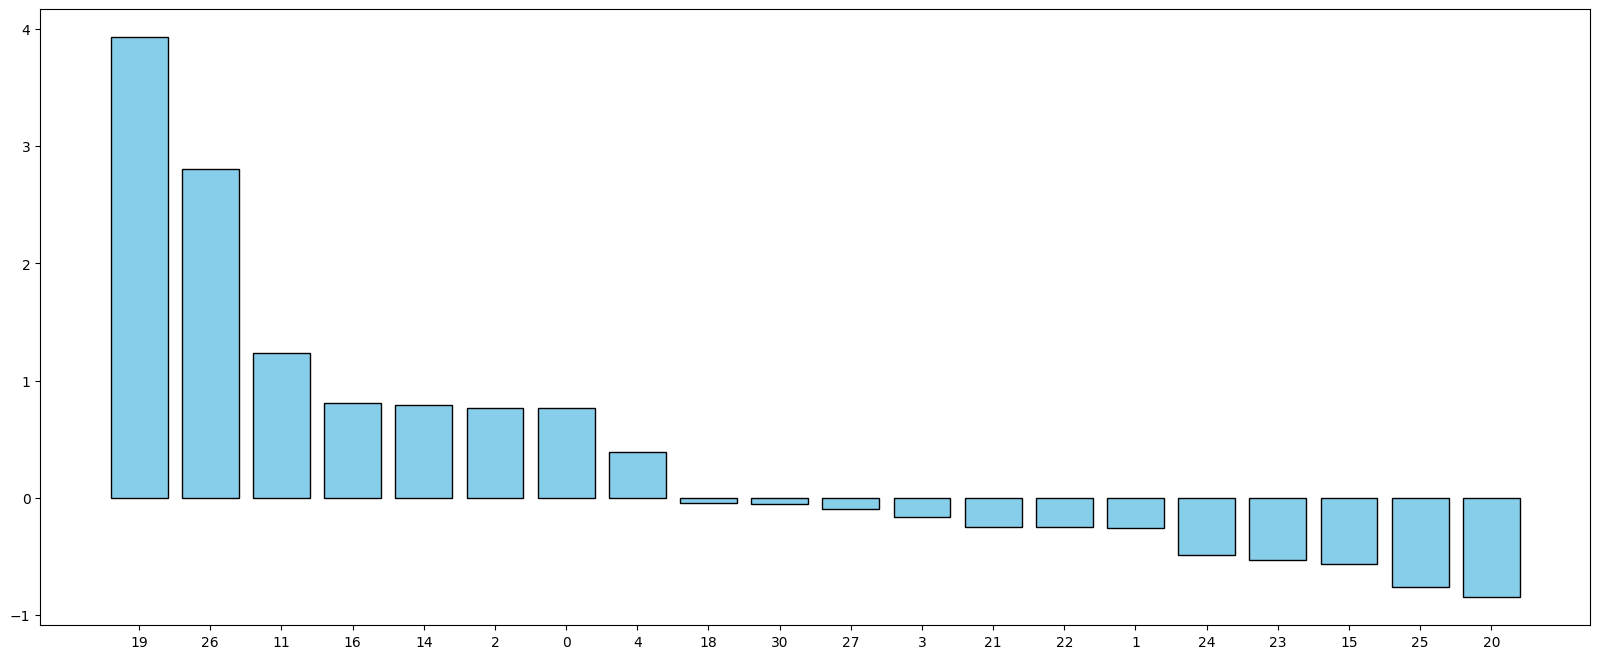

In [ ]:
word = "oil"
prob_layer = model.get_layer('sqrt_predicter')

word_idx = vectorizer.to_int(word)
distrib = prob_layer.distributions[word_idx]

plot_dict(sort_hl({str(i) : val for i, val in enumerate(distrib)}))

In [ ]:
sentence = random.choice(corpus.sentences)
index = random.randrange(5, len(sentence))
length = random.randrange(1,17)
print(length)
sentence = sentence[index - length:index]
print(concat_sentence(sentence))

sentence = ['/']

16
large carrots , peeled , sliced into ribbons 
 - 1 none large shallot , finely


/ 
 - 1 / 4 cup chopped onion and salt 
 directions : 
 directions : 
 directions : 



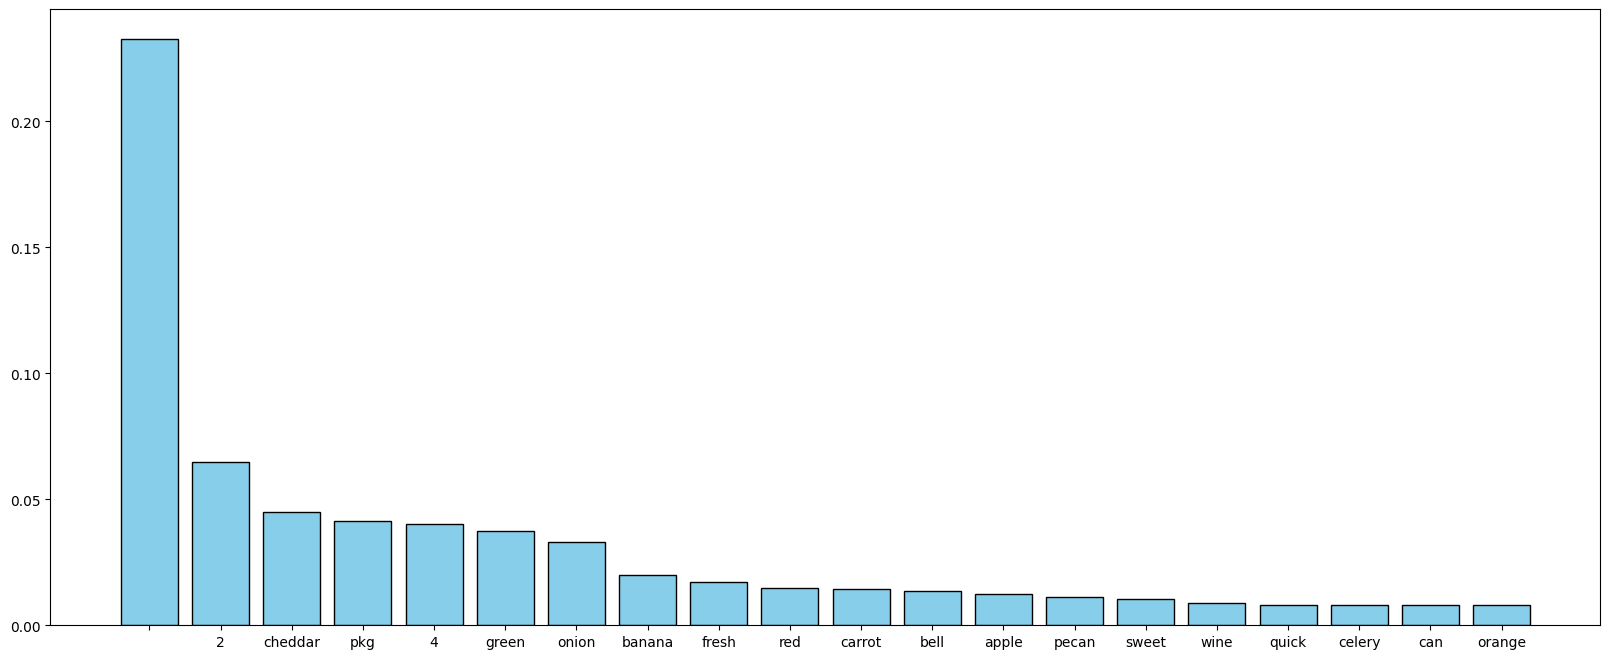

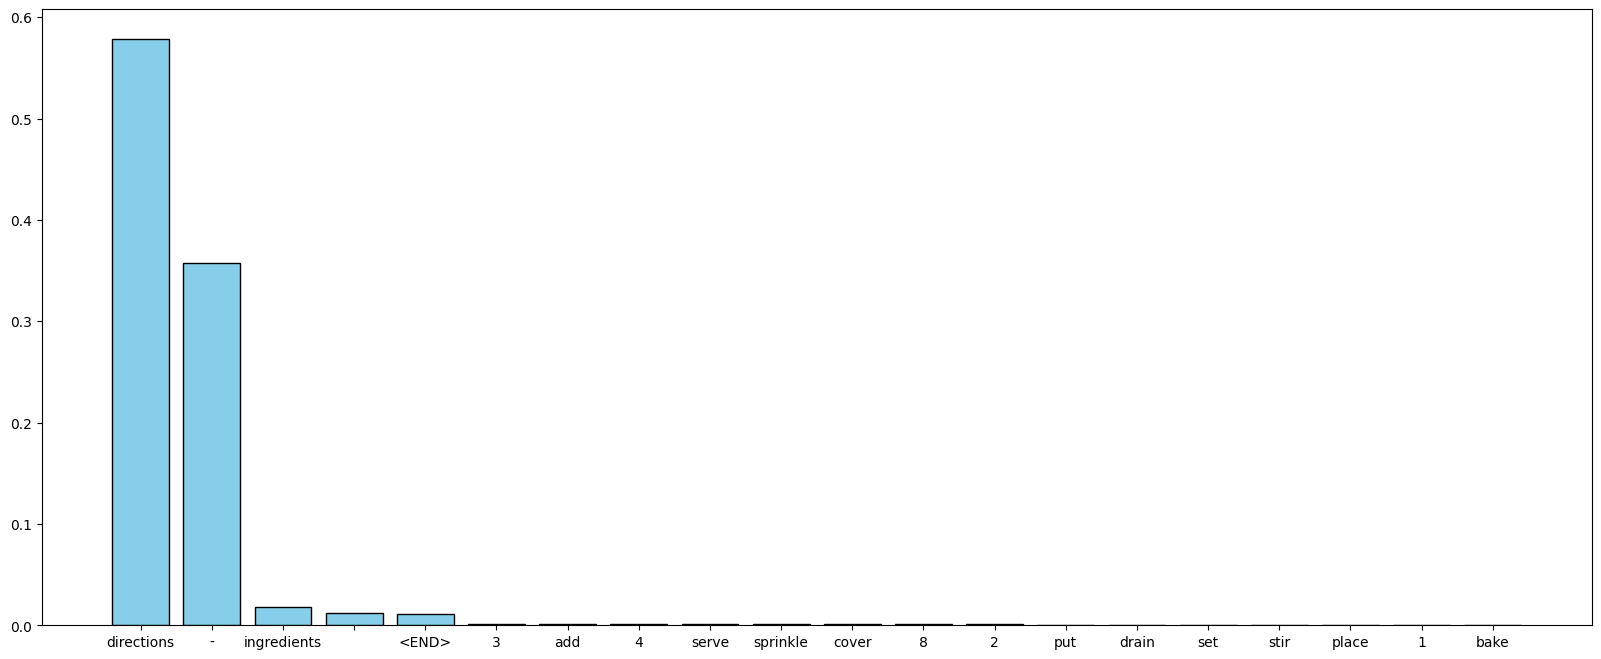

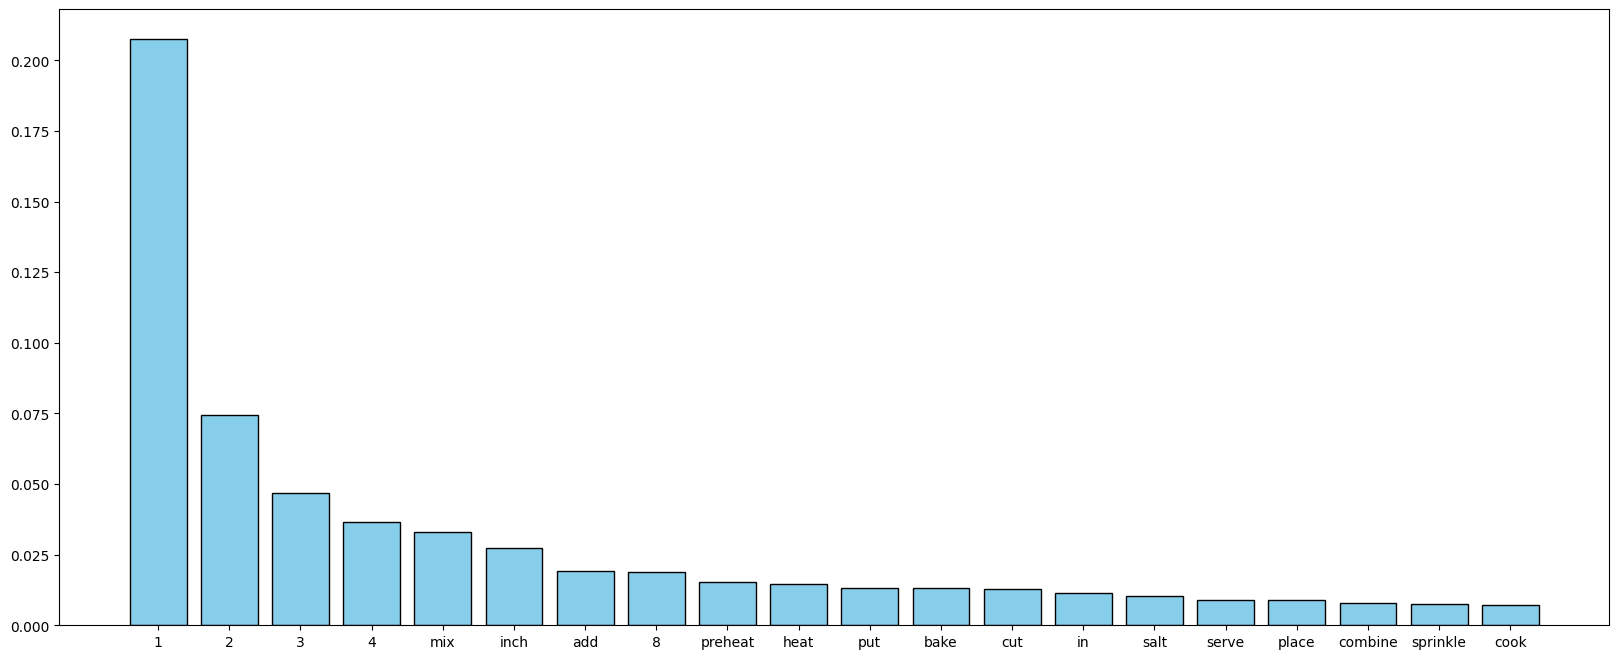

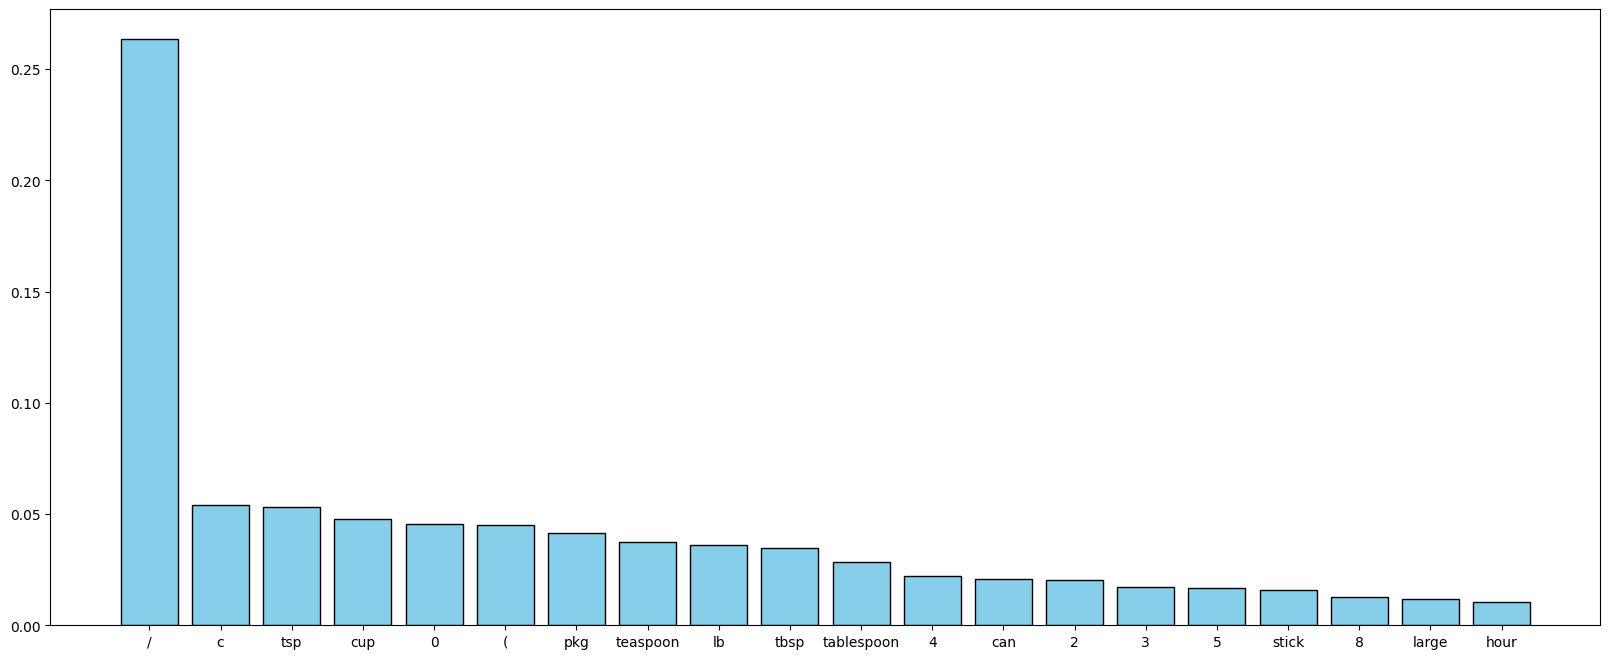

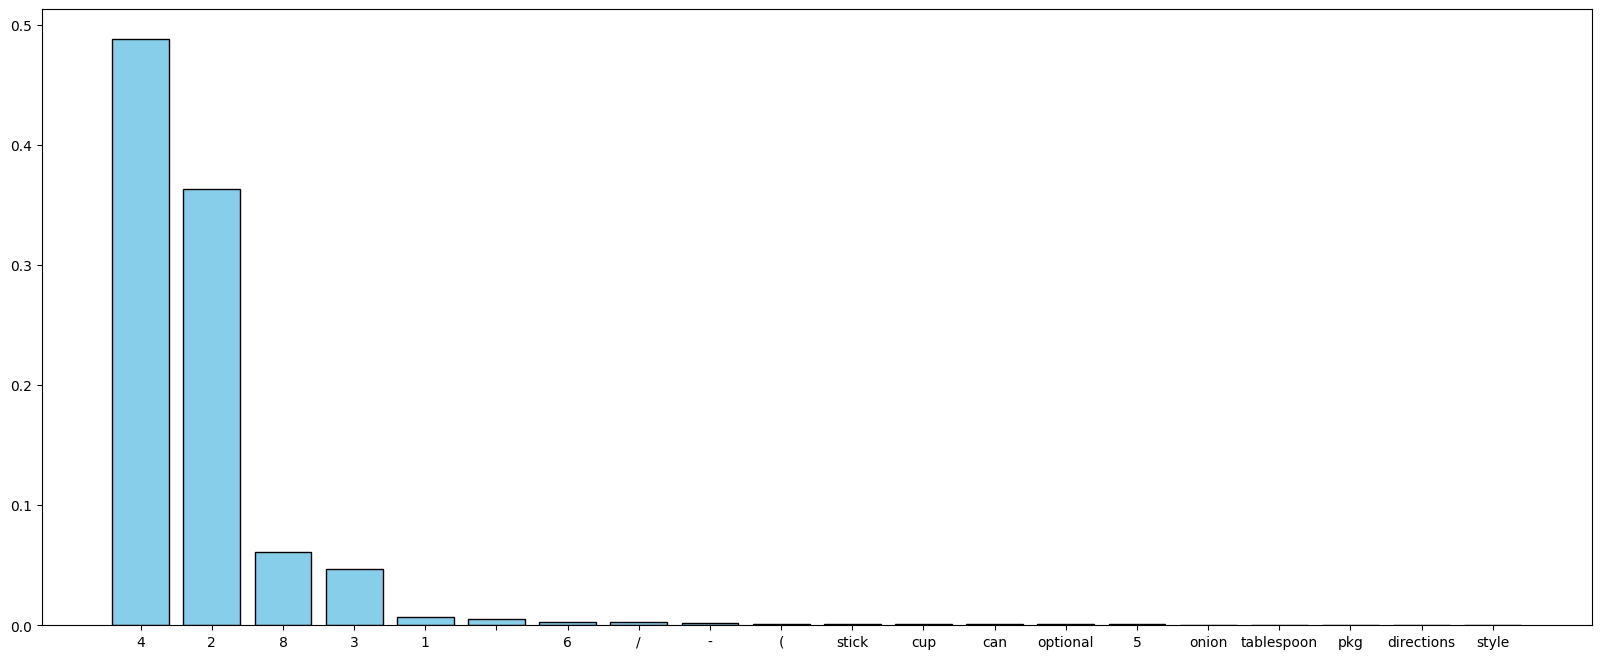

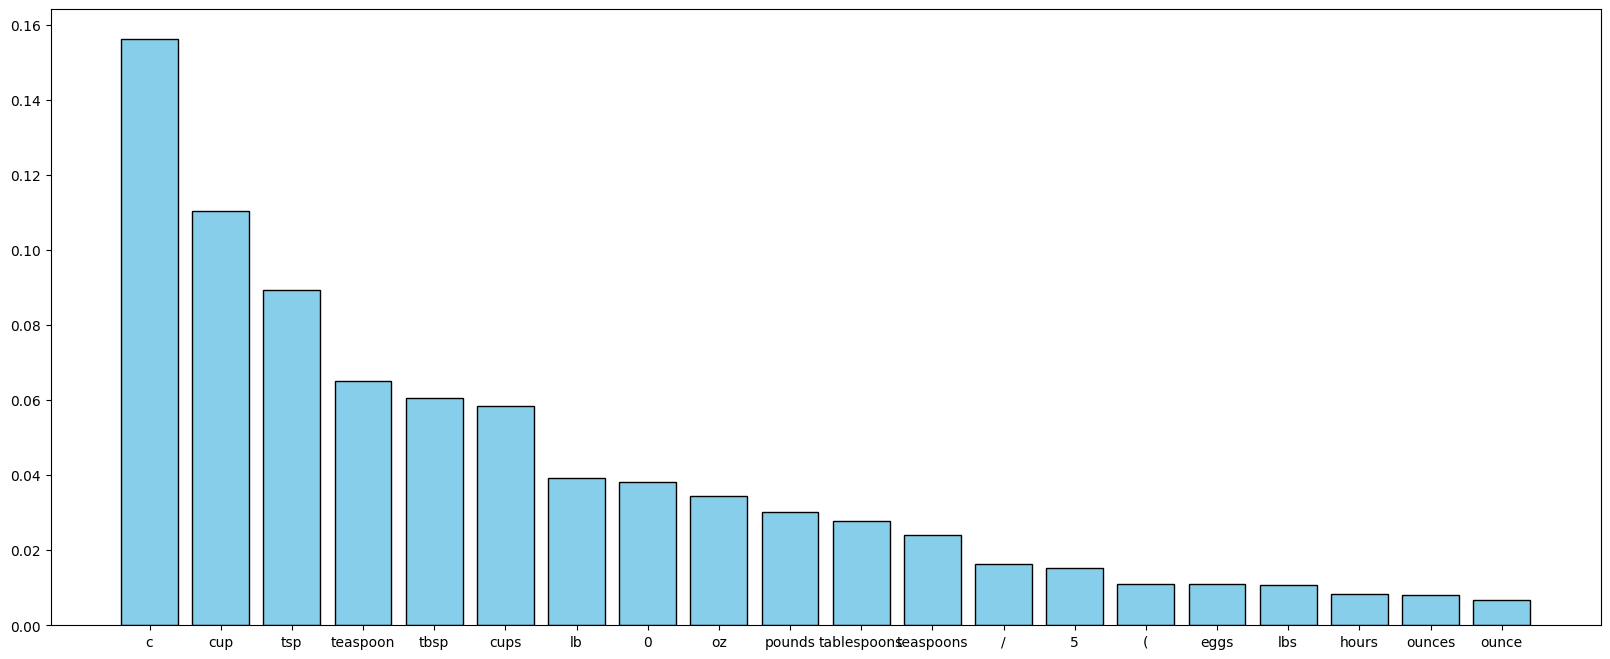

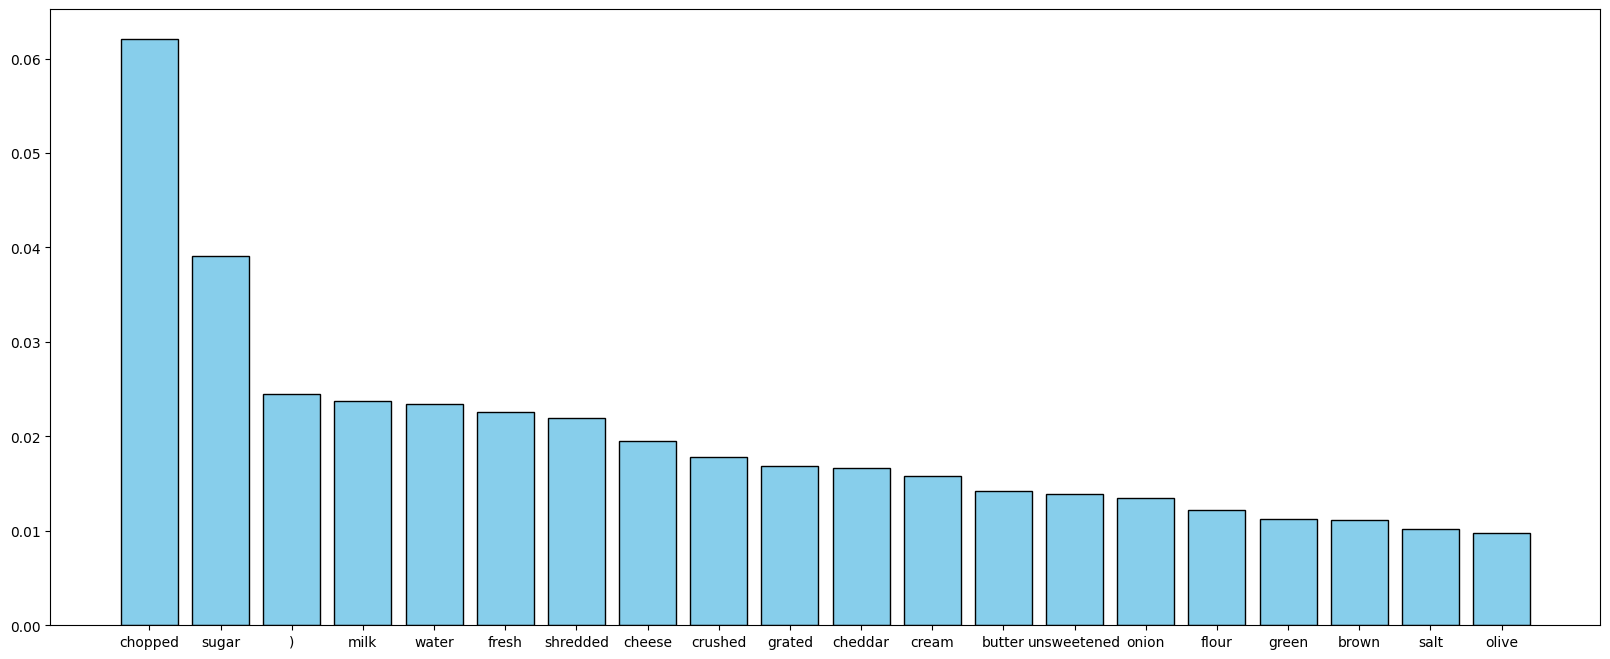

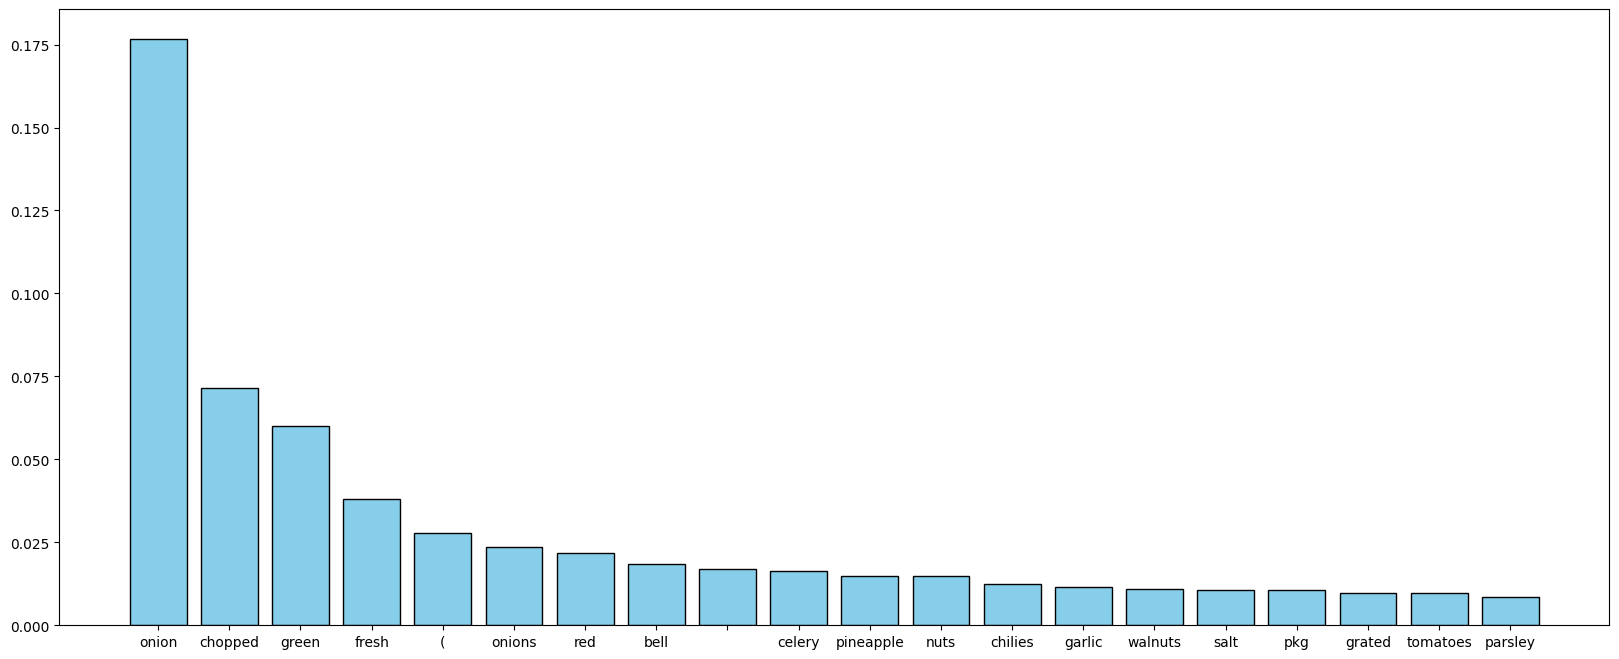

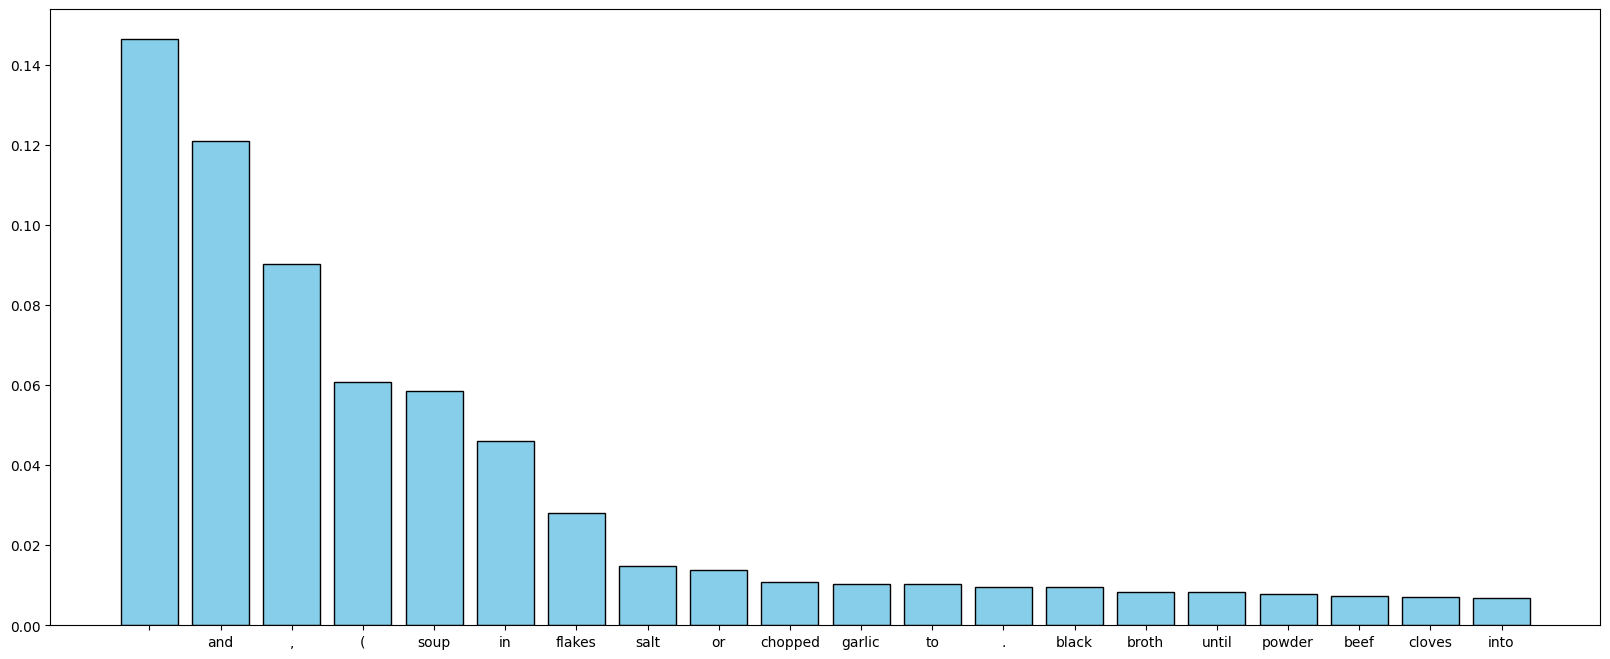

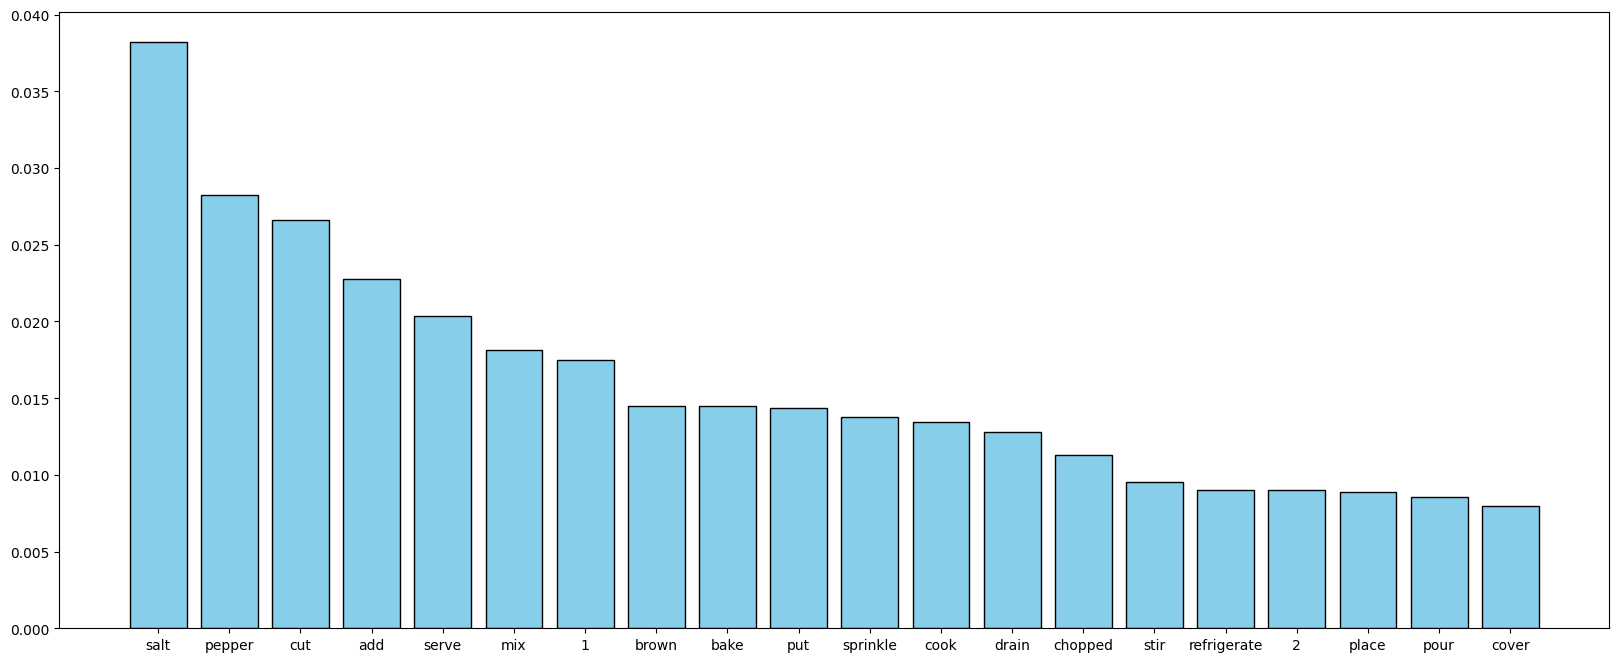

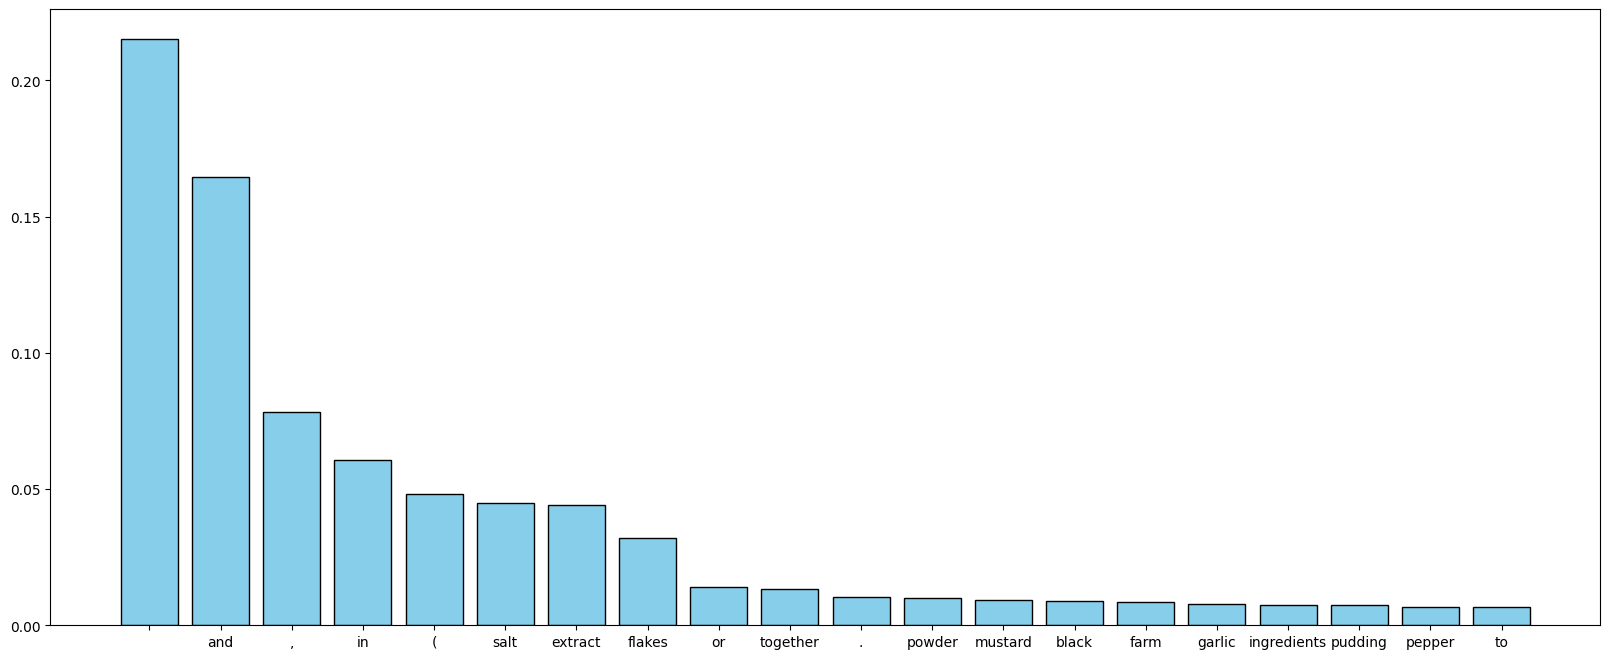

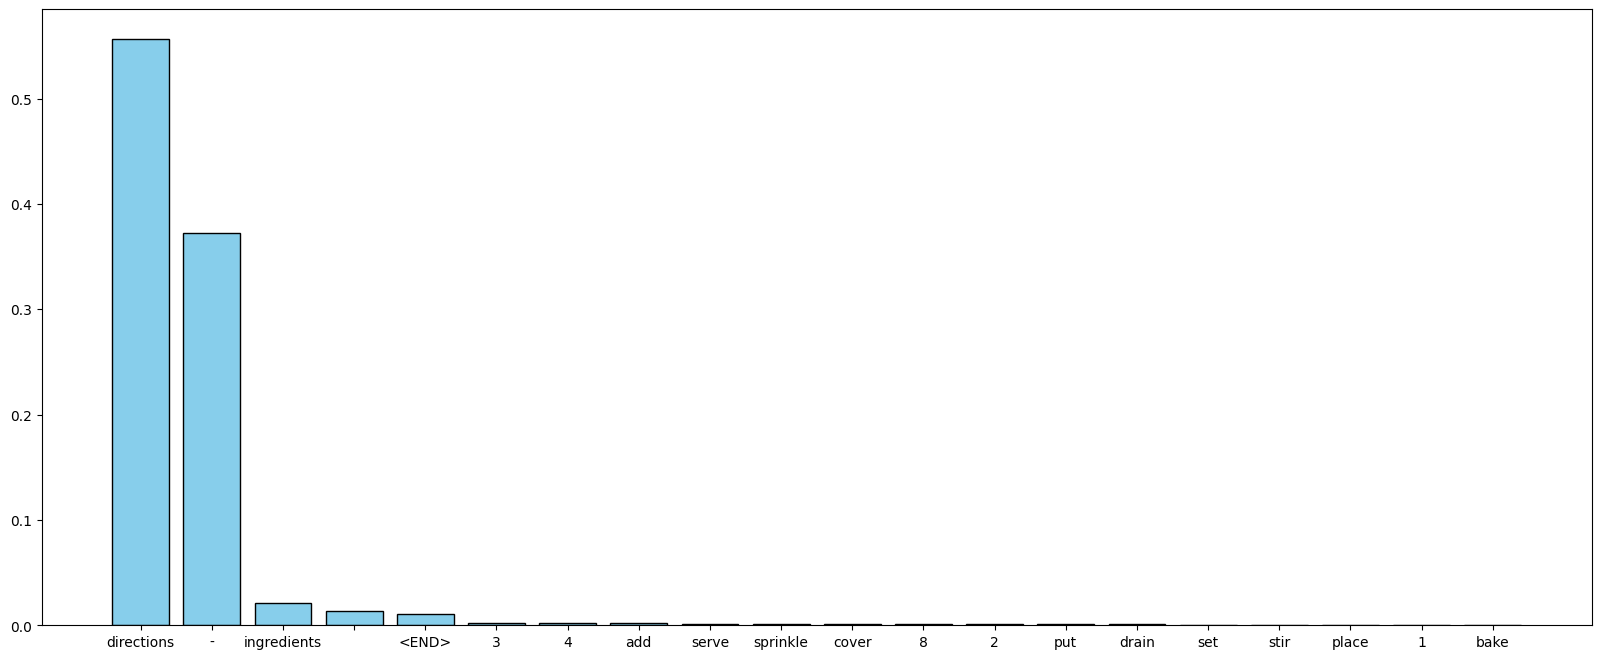

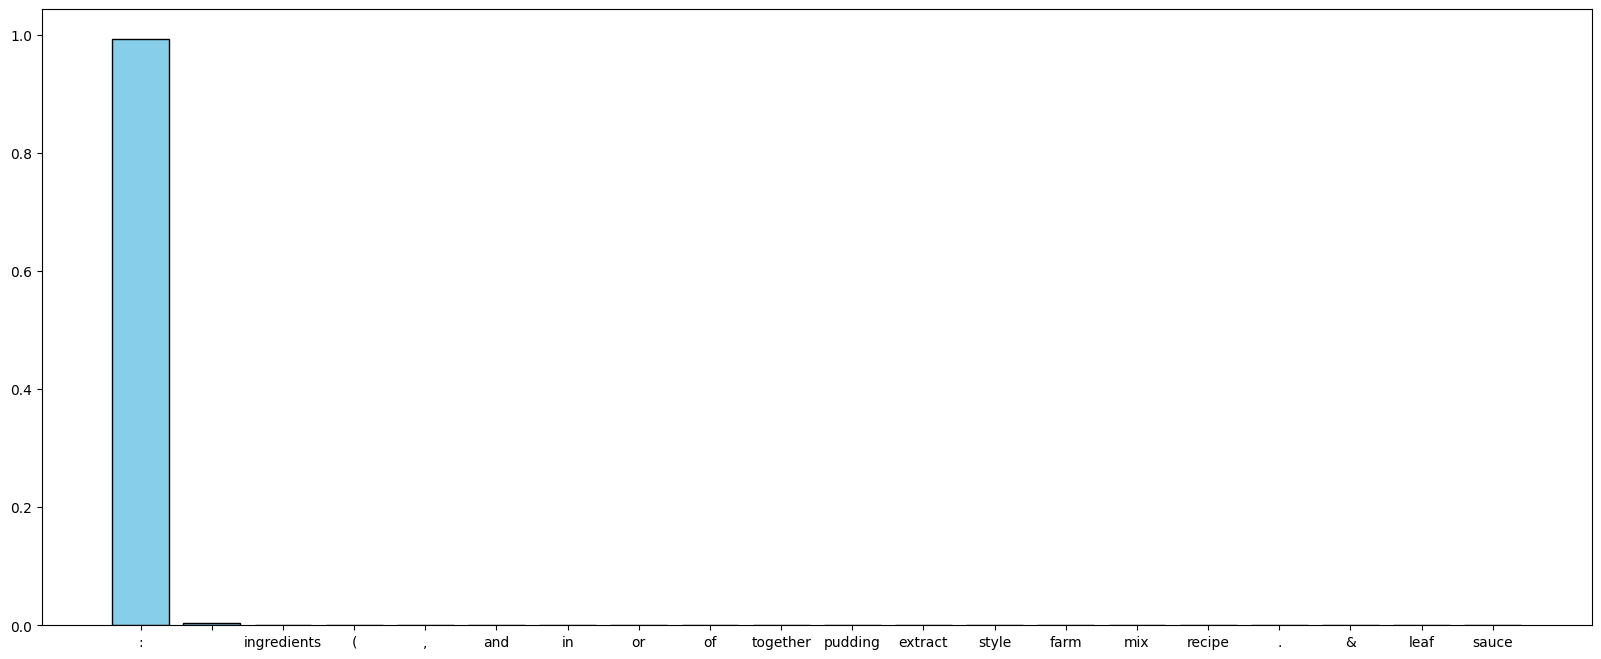

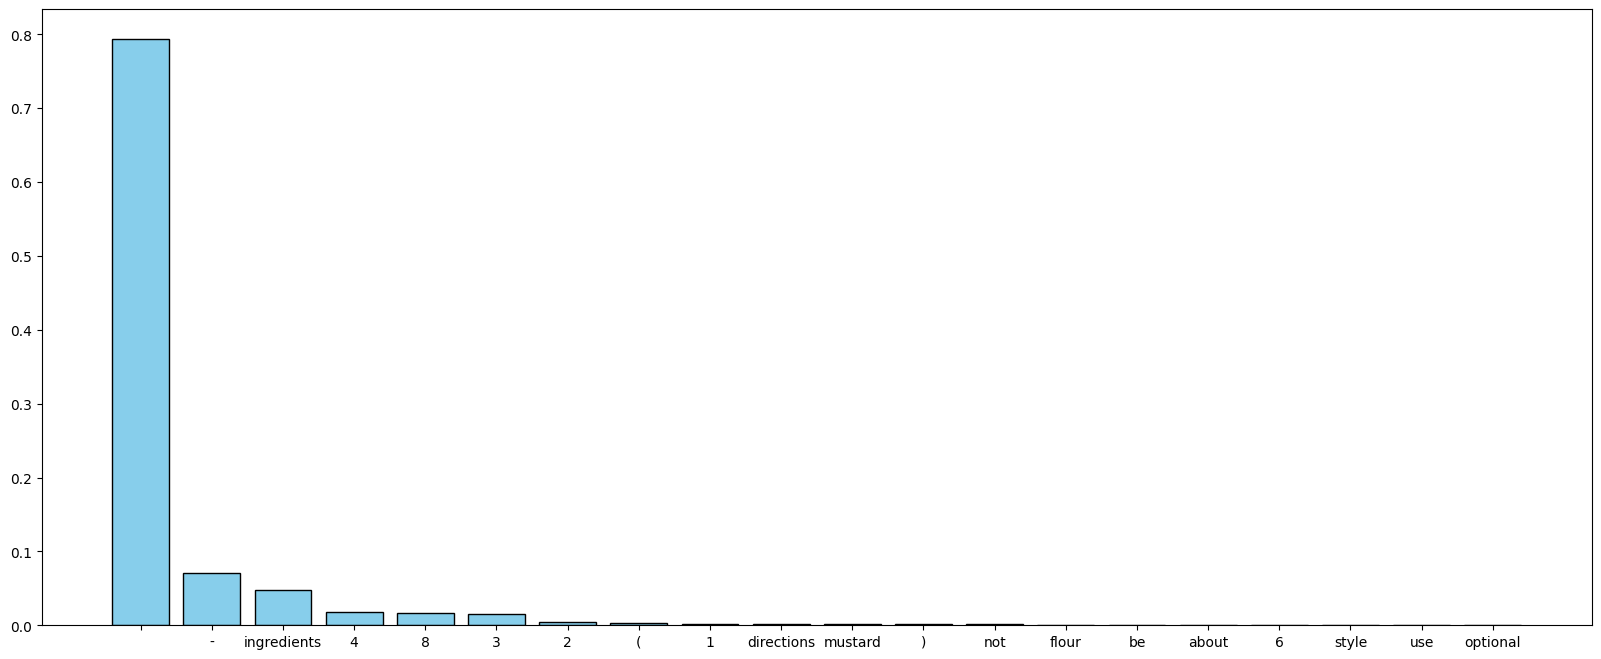

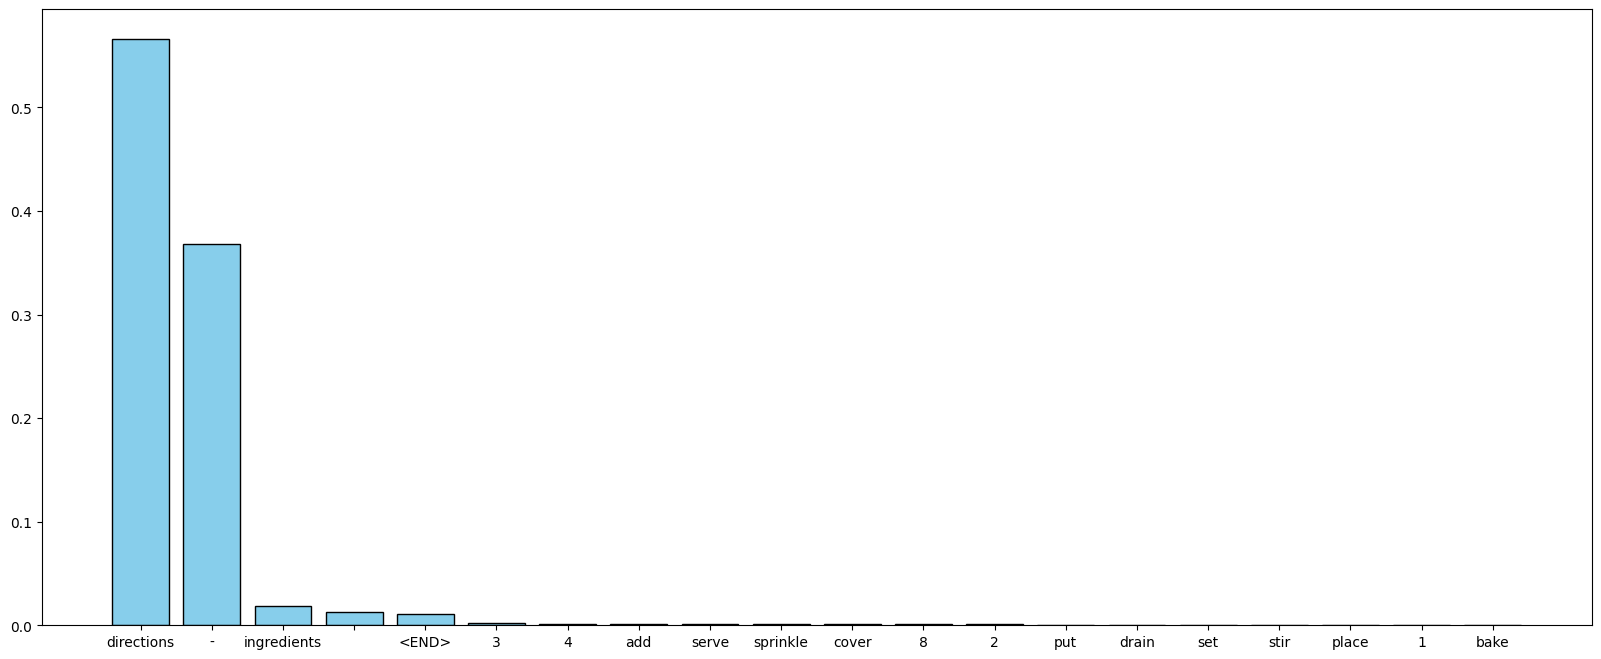

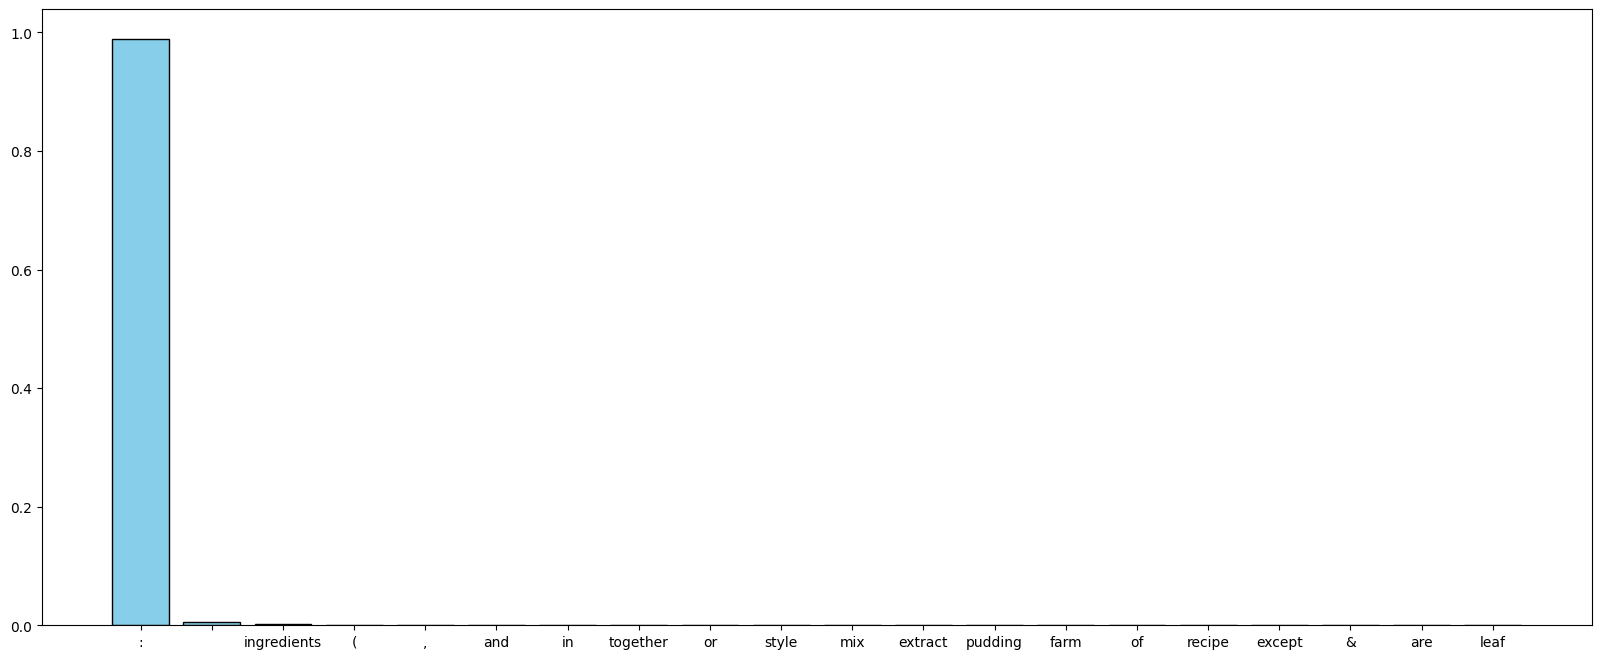

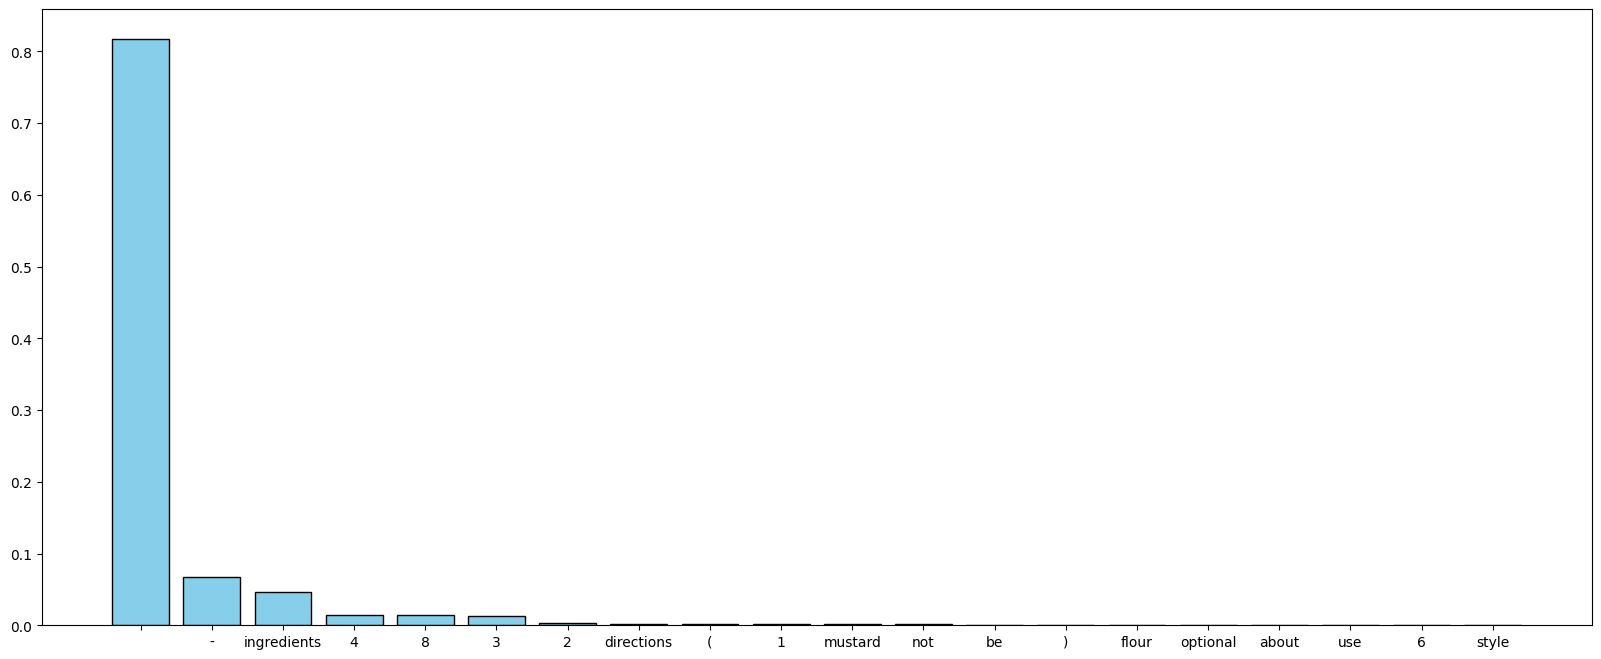

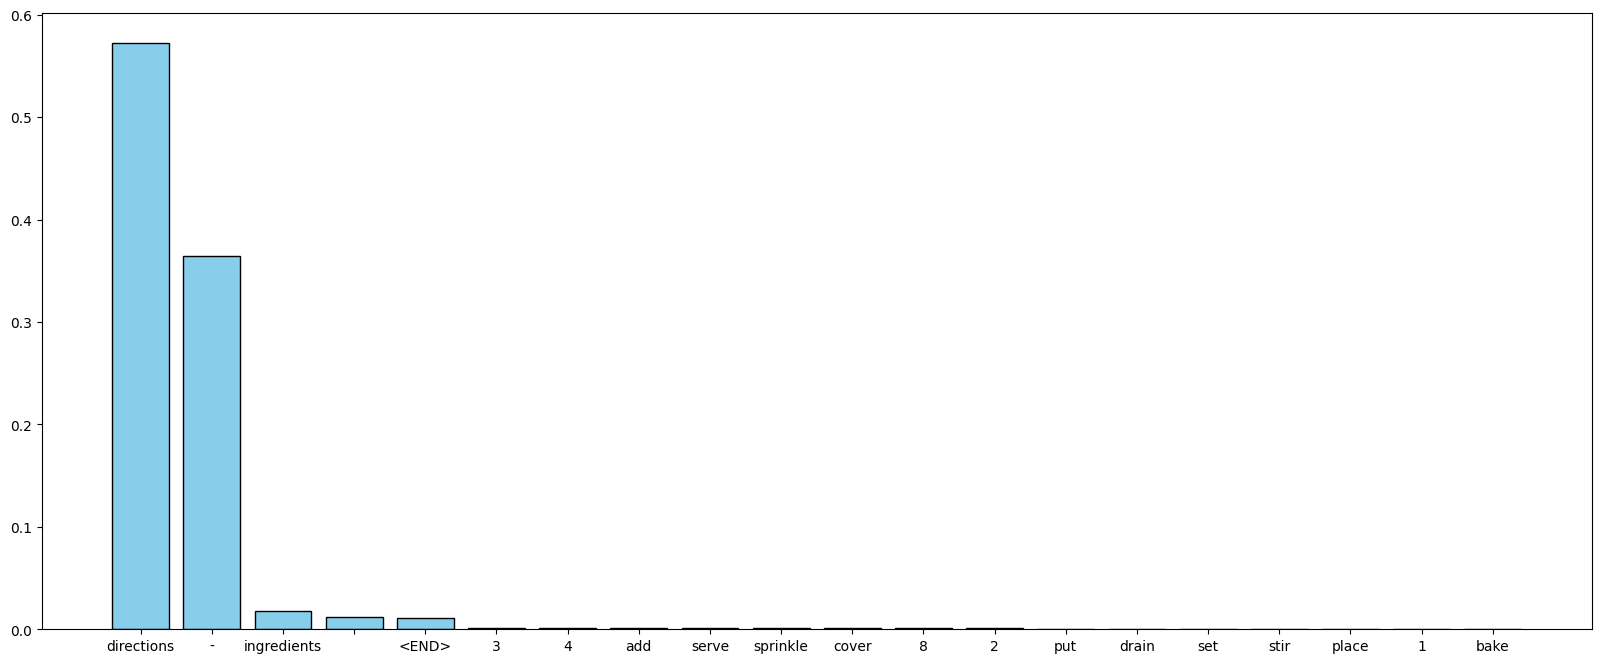

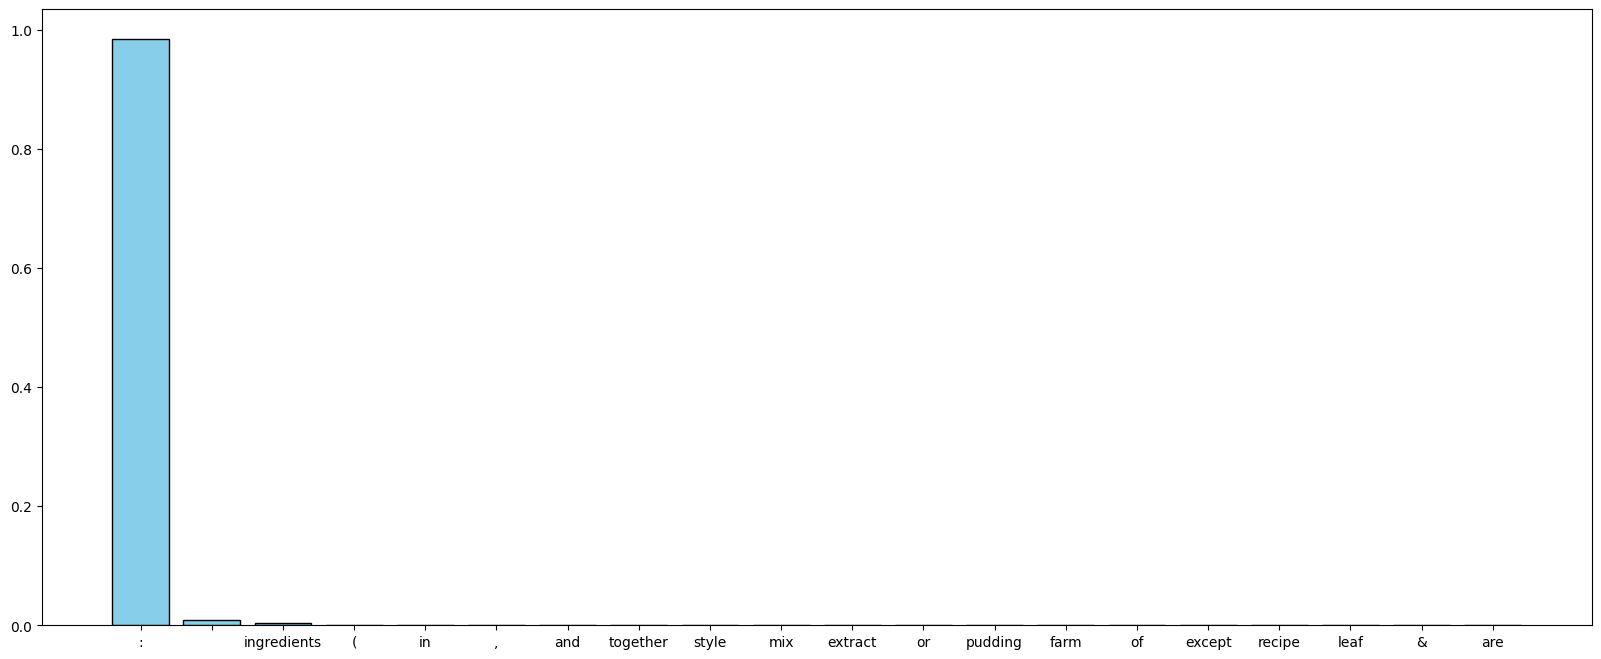

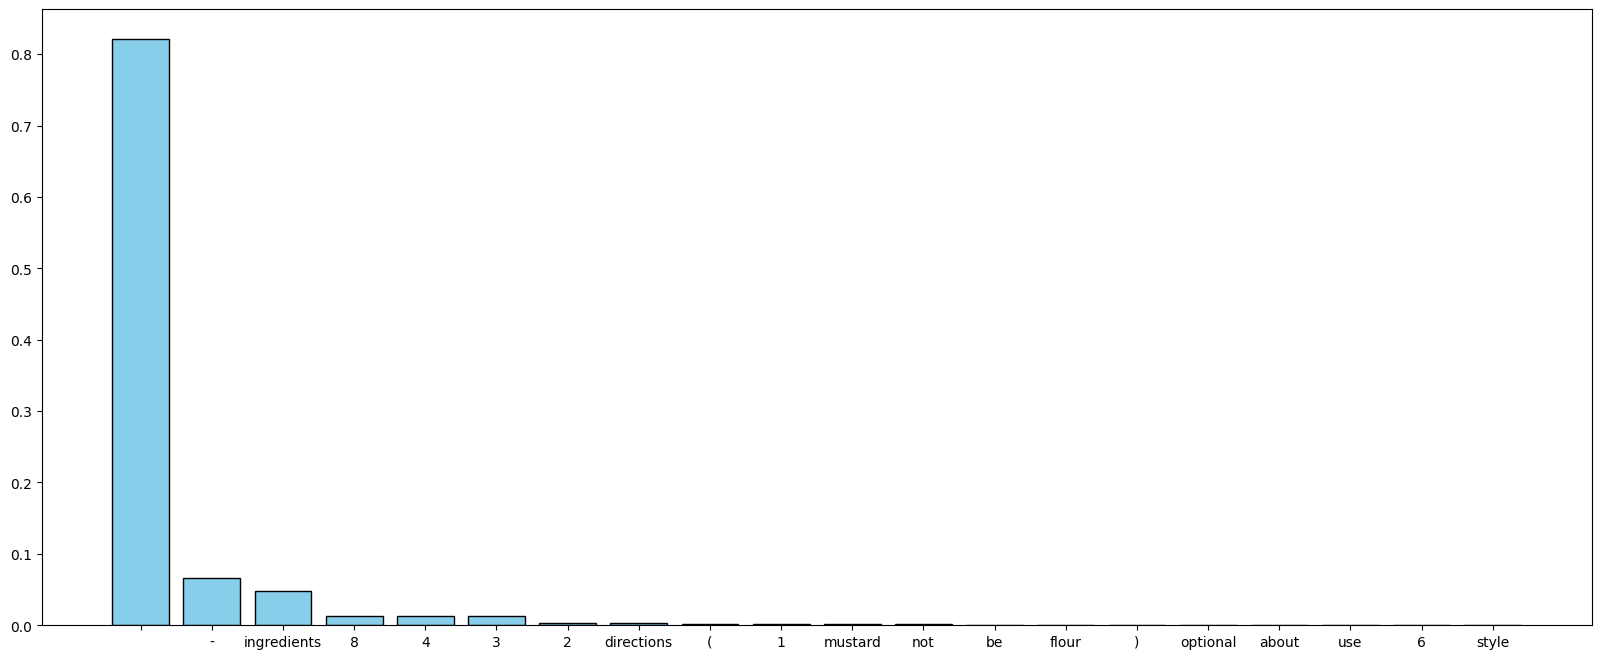

In [ ]:
temperature = 3

for i in range(20):
    q = sentence
    vectorized = keras.ops.expand_dims(vectorizer.vectorize(q), axis = 0)
    result = model.predict(vectorized, verbose = 0)[0]

    answer = corpus.vocab[np.argmax(result)]
    answer = corpus.vocab[tf.random.categorical(keras.ops.expand_dims(keras.ops.log(result**temperature), axis = 0), 1)[0][0]]
    sentence.append(answer)
    plot_dict(sort_hl({word : chance for word, chance in zip(corpus.vocab, result)}), length = 20)

print(concat_sentence(sentence))